In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install networkx
import networkx as nx

In [43]:
transition_probs = pd.read_csv('transition_probs.csv')

## Build transition matrix

In [44]:
tr_pr = transition_probs.pivot_table(
    index='score_diff_state', 
    columns='next_score_diff_state', 
    values='prob',
    fill_value=0 # replace missing transitions with 0 probability
)

## Plot Heatmap

C:\Users\wanns\AppData\Local\Temp\ipykernel_24264\1337454127.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Oranges')


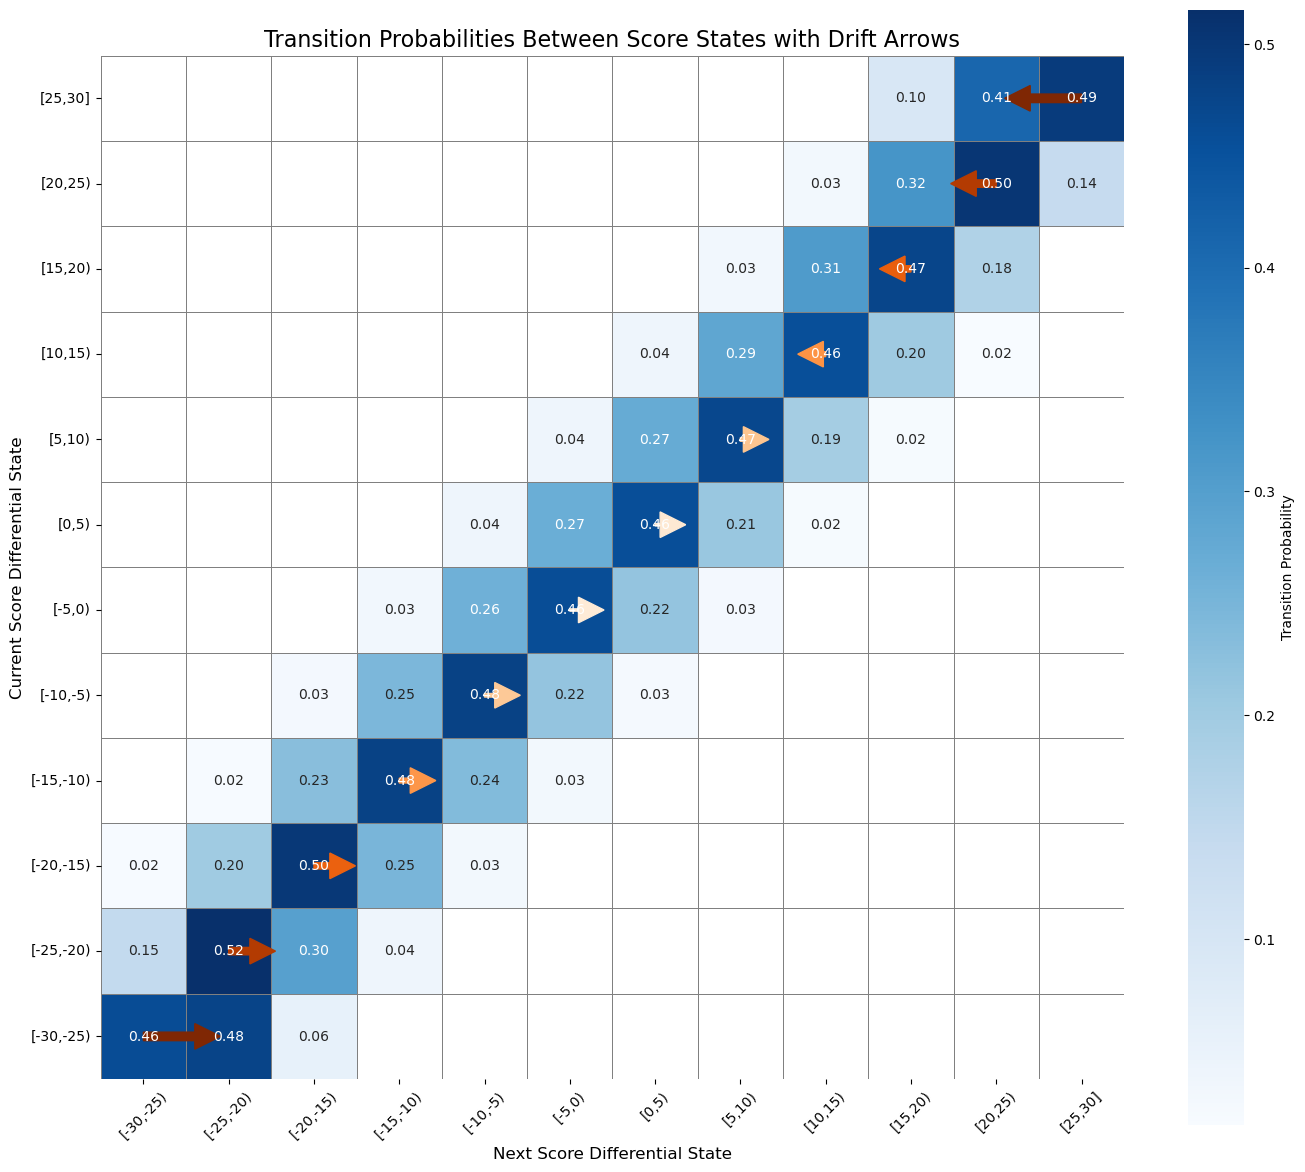

In [51]:
# reorder states
def extract_lower_bound(label):
    return float(label.strip('[]()').split(',')[0])

sorted_states = sorted(tr_pr.index, key=extract_lower_bound)

tr_pr_sorted = tr_pr.loc[sorted_states, sorted_states[::-1]]

states = tr_pr_sorted.index.tolist()
midpoints = np.array([extract_lower_bound(s) for s in states])
n = len(states)

import matplotlib.cm as cm

# Compute and map expected midpoint
expected_next = tr_pr_sorted.values @ midpoints[::-1]  # expected next score
expected_idx = np.array([np.interp(val, midpoints, np.arange(n)) for val in expected_next])

# Compute magnitude of expected change for scaling & normalize for color/thickness scaling
change_mag = expected_next - midpoints[::-1]
norm = np.abs(change_mag) / np.max(np.abs(change_mag))

tr_pr_no0 = tr_pr_sorted.where(tr_pr_sorted >= 0.01)

plt.figure(figsize=(14, 12))
sns.heatmap(
    tr_pr_no0,
    cmap='Blues',
    square=True,
    xticklabels=states,
    yticklabels=states[::-1],
    cbar_kws={'label': 'Transition Probability'},
    annot=True, fmt=".2f", linewidths=0.5, linecolor='gray'
)
plt.title('Transition Probabilities Between Score States with Drift Arrows', fontsize=16)
plt.xlabel('Next Score Differential State', fontsize=12)
plt.ylabel('Current Score Differential State', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Arrow colormap
cmap = cm.get_cmap('Oranges')

for i, row in enumerate(states[::-1]): 
    y = i + 0.5
    current_idx = n - 1 - i
    x_start = current_idx + 0.5
    x_end = expected_idx[current_idx] + 0.5
    dx = x_end - x_start
    
    # Arrow color and width scaled by magnitude
    color = cmap(norm[current_idx])
    width = 0.02 + 0.08 * norm[current_idx]
    
    plt.arrow(
        x=x_start,
        y=y,
        dx=dx,
        dy=0,
        color=color,
        width=width,
        head_width=0.3,
        head_length=0.3,
        length_includes_head=False
    )

plt.tight_layout()
plt.show()


C:\Users\wanns\AppData\Local\Temp\ipykernel_24264\1295167624.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  drift = transition_probs.groupby('s').apply(lambda x: np.sum((x['s_next'] - x['s']) * x['prob'])).reset_index(name='expected_change')


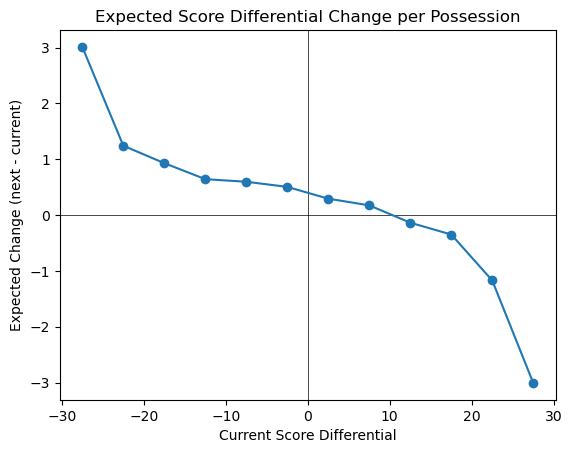

In [46]:
# extract numeric midpoints of bins
def midpoint(b):
    b = b.strip('[]()')
    lo, hi = map(float, b.split(','))
    return (lo + hi) / 2

transition_probs['s'] = transition_probs['score_diff_state'].apply(midpoint)
transition_probs['s_next'] = transition_probs['next_score_diff_state'].apply(midpoint)

drift = transition_probs.groupby('s').apply(lambda x: np.sum((x['s_next'] - x['s']) * x['prob'])).reset_index(name='expected_change')

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.plot(drift['s'], drift['expected_change'], marker='o')
plt.title('Expected Score Differential Change per Possession')
plt.xlabel('Current Score Differential')
plt.ylabel('Expected Change (next - current)')
plt.show()

## Simulate 2nd half of UVA vs. NC Central (+17 initial score state)

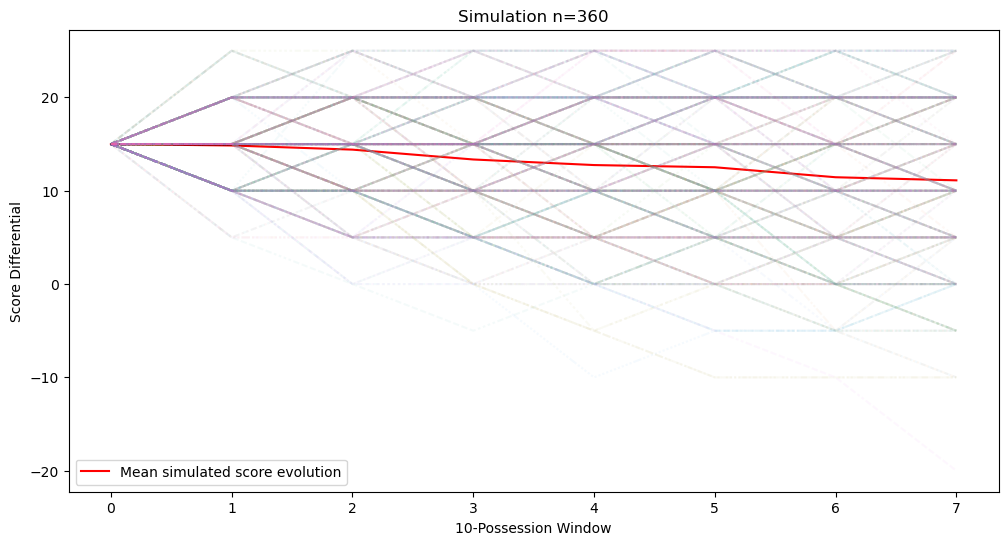

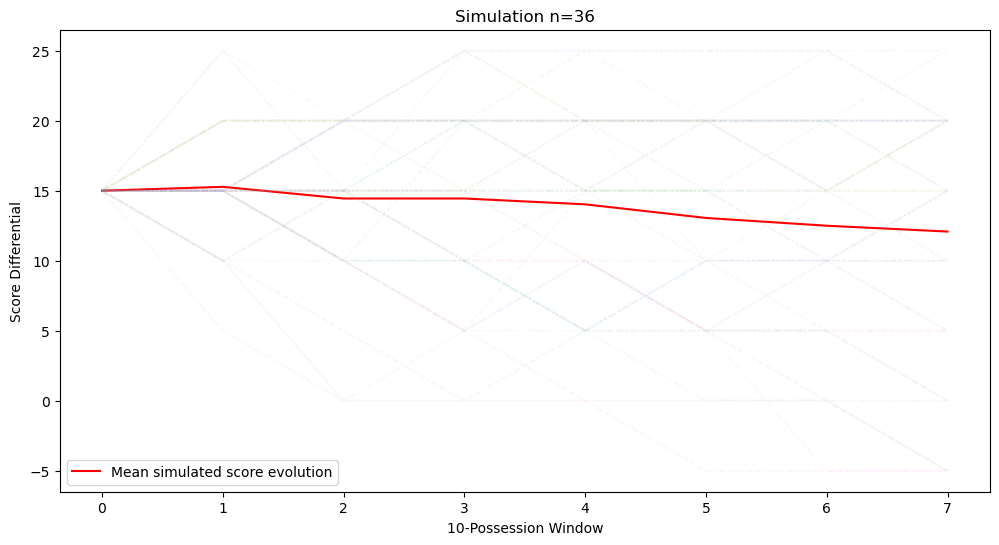

In [47]:
states = tr_pr.index.tolist()
state_to_idx = {s: i for i, s in enumerate(states)}
idx_to_state = {i: s for i, s in enumerate(states)}

# Convert transition matrix to np array
P = tr_pr.values  # rows sum to 1

# set initial state +17
init_state = '[15,20)'
init_idx = state_to_idx[init_state]

T = 7 # time steps
n_sim = 360 # simulations

rng = np.random.default_rng(seed=42)

# Simulate paths
paths = np.zeros((T + 1, n_sim), dtype=int)
paths[0, :] = init_idx

for t in range(1, T + 1):
    for sim in range(n_sim):
        current_idx = paths[t - 1, sim]
        paths[t, sim] = rng.choice(
            len(states), 
            p=P[current_idx]
        )

# Map categorical states to numeric score differentials
score_values = np.array([extract_lower_bound(s) for s in states])
scores = score_values[paths]

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(T + 1), y=scores.mean(axis=1), color='red', label='Mean simulated score evolution')
sns.lineplot(data=scores, alpha=0.05, legend=False)
plt.xlabel('10-Possession Window')
plt.ylabel('Score Differential')
plt.title('Simulation n=360')
plt.legend()
plt.show()

init_state = '[15,20)'
init_idx = state_to_idx[init_state]
n_sim = 36 # simulations

# Simulate paths
paths = np.zeros((T + 1, n_sim), dtype=int)
paths[0, :] = init_idx

for t in range(1, T + 1):
    for sim in range(n_sim):
        current_idx = paths[t - 1, sim]
        paths[t, sim] = rng.choice(
            len(states), 
            p=P[current_idx]
        )

# Map categorical states to numeric score differentials
score_values = np.array([extract_lower_bound(s) for s in states])
scores = score_values[paths]

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(T + 1), y=scores.mean(axis=1), color='red', label='Mean simulated score evolution')
sns.lineplot(data=scores, alpha=0.05, legend=False)
plt.xlabel('10-Possession Window')
plt.ylabel('Score Differential')
plt.title('Simulation n=36')
plt.legend()
plt.show()

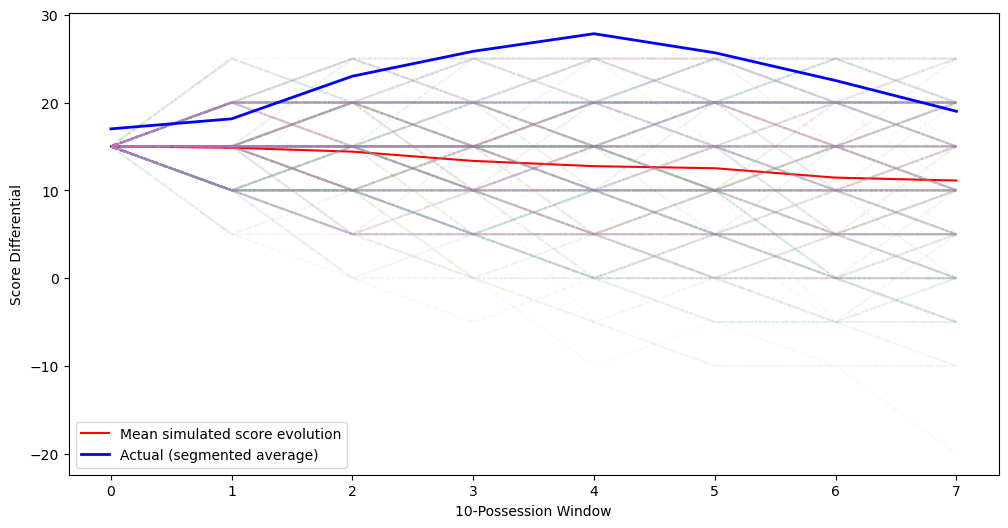

In [48]:
actual_score_differentials = [17, 15, 17, 18, 19, 21, 20, 19, 21, 23, 26, 25, 24, 21, 24, 25, 26, 28, 31, 28, 26, 28, 27, 30, 28, 27, 25, 28, 27, 25, 22, 25, 24, 23, 21, 20, 22, 20, 18, 20, 19, 18, 19]
states = tr_pr.index.tolist()
state_to_idx = {s: i for i, s in enumerate(states)}
idx_to_state = {i: s for i, s in enumerate(states)}

# Convert transition matrix to np array
P = tr_pr.values  # rows sum to 1

# Set initial state (+17)
init_state = '[15,20)'
init_idx = state_to_idx[init_state]

T = 7 # time steps
n_sim = 360 # simulations

rng = np.random.default_rng(seed=42)

# Simulate paths
paths = np.zeros((T + 1, n_sim), dtype=int)
paths[0, :] = init_idx

for t in range(1, T + 1):
    for sim in range(n_sim):
        current_idx = paths[t - 1, sim]
        paths[t, sim] = rng.choice(
            len(states), 
            p=P[current_idx]
        )

# Map categorical states to numeric score differentials
score_values = np.array([extract_lower_bound(s) for s in states])
scores = score_values[paths]

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(T + 1), y=scores.mean(axis=1), color='red', label='Mean simulated score evolution')
sns.lineplot(data=scores, alpha=0.05, legend=False)
# aggregate actual score differentials into T segments and produce T+1 points (keep start/end as actual)
arr = np.array(actual_score_differentials)
chunks = np.array_split(arr, T)
chunk_means = np.array([c.mean() for c in chunks])

reduced_actual = np.empty(T + 1)
reduced_actual[0] = arr[0]
reduced_actual[-1] = arr[-1]
if T > 1:
    reduced_actual[1:-1] = chunk_means[:-1]  # use the first T-1 chunk means for interior points

plt.plot(range(T + 1), reduced_actual, color='blue', linewidth=2, label='Actual (segmented average)')
plt.xlabel('10-Possession Window')
plt.ylabel('Score Differential')
plt.legend()
plt.show()
